# Recordes de Temperatura em Ann Arbor (2015)

O objetivo deste estudo é a elaboração de uma visualização acerca dos recordes de temperatura atingidos no ano de 2015 na cidade de Ann Arbor, Michigan, EUA. Mais precisamente, os recordes são em relação às temperaturas mínimas e máximas registradas no período de 10 anos entre 2005 e 2014. Os dados provêm de um subconjunto do [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). Ressaltamos que o GHCN-Daily compreende o registro diário de temperatura a partir de milhares de estações terrestres instaladas ao redor do mundo.

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

%matplotlib inline

## Importação e descrição do conjunto de dados

Temos disponíveis as seguintes informações para cada registro de temperatura:

* **id** : código de identificação da estação coletora
* **date** : data no formato YYYY-MM-DD (e.g. 2012-01-24 = 24 de Janeiro de 2012)
* **element** : indicador do tipo de registro, podendo ser:
    * 'TMAX' : caso  seja um registro de temperatura diária máxima
    * 'TMIN' : caso seja um registro de temperatura diária mínima
* **data_value** : temperatura (em décimos de ºC)

Este conjunto contém apenas dados de estações próximas a **Ann Arbor**. Também devemos considerar que cada estação de coleta reportou uma temperatura de mínimo e outra de máximo durante cada dia ao longo do período de janeiro de 2005 a dezembro de 2015.

In [95]:
df = pd.read_csv('AnnArborMinMaxTemperature.csv')
df

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106
...,...,...,...,...
165080,USC00205822,2015-06-09,TMAX,256
165081,USC00205822,2009-10-06,TMAX,167
165082,USC00205050,2014-07-14,TMAX,283
165083,USC00200230,2006-11-29,TMIN,117


Agora faremos a coluna *Date* ser o índice do dataframe e ordenaremos os dados pela cronologia de coleta. Em adição, renomearemos a coluna *Data_Value* para fins de simplicidade e converteremos as temperaturas de décimos de graus Celsius para apenas graus Celsius.

In [96]:
df = df.set_index('Date')
df = df.sort_index()
df = df.rename(columns={'Data_Value': 'Value'})
df['Value'] = df['Value']/10.0
df

,ID,Element,Value
Date,,,
2005-01-01,USW00004848,TMIN,0.0
2005-01-01,USC00207320,TMAX,15.0
2005-01-01,USC00207320,TMIN,-1.1
2005-01-01,USW00014833,TMIN,-4.4
2005-01-01,USW00014833,TMAX,3.3
...,...,...,...
2015-12-31,USC00200032,TMAX,1.1
2015-12-31,USC00205050,TMIN,-1.7
2015-12-31,USC00208202,TMAX,0.0


Separaremos o dataset por intervalos de tempo, sendo:
1. Temperaturas registradas de **2005 a 2014**: essas formarão a informação histórica a ser quebrada por possíveis recordes em 2015.
2. Temperaturas registradas em **2015**: serão os possíveis recordes.

Feito isso, para ambos os dataframes removeremos o ano e manteremos apenas o dia e o mês como índice. Isso permite que foquemos nas diferentes temperaturas de mínimo e máximo de cada dia do ano ao longo dos anos. 

In [97]:
df2005_2014 = df[:'2014-12-31']         # dados anteriores a 31 de dezembro de 2014
df2015 = df['2015-01-01':]              # dados posteriores a 1 de janeiro de 2015

df2005_2014.index = df2005_2014.index.str[5:]       
df2015.index = df2015.index.str[5:]

df2005_2014

,ID,Element,Value
Date,,,
01-01,USW00004848,TMIN,0.0
01-01,USC00207320,TMAX,15.0
01-01,USC00207320,TMIN,-1.1
01-01,USW00014833,TMIN,-4.4
01-01,USW00014833,TMAX,3.3
...,...,...,...
12-31,USC00202308,TMIN,-10.0
12-31,USC00205563,TMAX,-2.8
12-31,USC00205451,TMIN,-11.1


Levando em consideração que a distinção de ano foram removidas. A função *min_and_max* agrupa todas as medições feitas em um mesmo dia do ano pelas diversas estações de coleta. Em seguida, para cada dia, identifica a menor das emperaturas mínimas e a maior das temperaturas máximas, construindo um série de mínimos e outra de máximos. Cada uma deve ter tamanho 365 ao final da execução.

Construiremos uma série de mínimos e outra de máximos para o período 2005-2014. E também outra de mínimos e de máximos para 2015.

In [98]:
def min_and_max(dataframe):
    minSerie = pd.Series(dtype='float64')
    maxSerie = pd.Series(dtype='float64')

    for group, frame in dataframe.groupby(level=0):
        minFrame = frame[frame['Element']=='TMIN']
        minValue = minFrame['Value'].min()
        minSerie = minSerie.append(pd.Series([minValue], index=[group]))

        maxFrame = frame[frame['Element']=='TMAX']
        maxValue = maxFrame['Value'].max()
        maxSerie = maxSerie.append(pd.Series([maxValue], index=[group]))
    
    return minSerie, maxSerie

minSerie2005_2014, maxSerie2005_2014 = min_and_max(df2005_2014)
minSerie2015, maxSerie2015 = min_and_max(df2015)

A seguir, faremos o reconhecimento dos recordes batidos em 2015. Utilizaremos compreensão de listas para construir os recordes de mínimos e recordes de máximo.
* Se uma temperatura de mínimo de um dia x de 2015 for menor que uma temperatura de mínimo do mesmo dia x em 2005-2014, então houve um recorde de mínimo.
* Se uma temperatura de máximo de um dia x de 2015 for maior que uma temperatura de máximo do mesmo dia x em 2005-2014, então houve um recorde de máximo.

In [99]:
minRecords2015 = [minSerie2015[x] if minSerie2015[x] < minSerie2005_2014[x] else np.nan for x in minSerie2015.index]
maxRecords2015 = [maxSerie2015[x] if maxSerie2015[x] > maxSerie2005_2014[x] else np.nan for x in maxSerie2015.index]

Removendo o dia 29 de fevereiro da série história de 2005-2014, pois 2015 não foi um ano bissexto e esta inconsistência pode acarretar em erros durante a elaboração da visualização final.

In [100]:
maxSerie2005_2014 = maxSerie2005_2014.drop(labels='02-29')
minSerie2005_2014 = minSerie2005_2014.drop(labels='02-29')

## Construindo a visualização

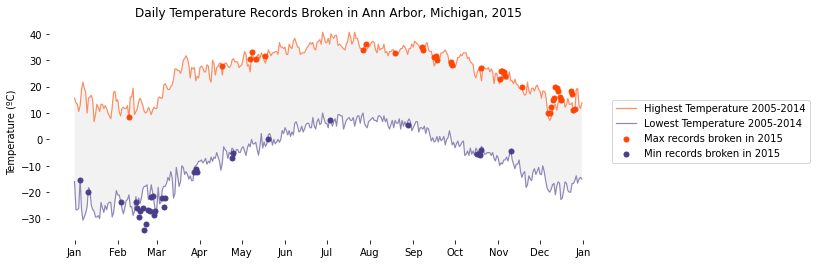

In [101]:
# Vetor de datas que servem como labels para o eixo x
datesX = np.arange('2015-01-01','2016-01-01', dtype='datetime64[D]')
datesX = list(map(pd.to_datetime, datesX))

plt.figure(figsize=(10,4))

# Dois gráficos de linha, sendo uma linha para as temperaturas de mínimo e outra para as de máximo (2005-2014)
plt.plot(datesX, maxSerie2005_2014, label='Highest Temperature 2005-2014', alpha=0.6, lw=1.2, color='orangered')
plt.plot(datesX, minSerie2005_2014, label='Lowest Temperature 2005-2014', alpha=0.6, lw=1.2, color='darkslateblue')

# Dois gráficos de pontos com os recordes de temperaturas de mínimo e de máximo quebrados em 2015
plt.scatter(datesX, maxRecords2015, label='Max records broken in 2015', s=25, color='orangered')
plt.scatter(datesX, minRecords2015, label='Min records broken in 2015', s=25, color='darkslateblue')

plt.gca().fill_between(datesX, minSerie2005_2014, maxSerie2005_2014, facecolor='grey', alpha=0.1)
plt.title('Daily Temperature Records Broken in Ann Arbor, Michigan, 2015')
plt.ylabel('Temperature (ºC)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = plt.gca()
ax.spines['top'].set_visible(False)           # Removendo os 4 spines (topo, direita, baixo, esquerda)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)                
ax.xaxis.set_major_locator(mdates.MonthLocator())            # Formatando para que todos os 12 meses tenham labels no eixo x 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))      # Formatando para que os meses sejam representados por siglas
plt.savefig('daily_temp.png', dpi=400, bbox_inches='tight')

* Podemos ver pela tendência geral das linhas laranja e azul que os meses de maio a outubro tem temperaturas mais altas e entre os meses de novembro e abril as temperaturas caem. Representando claramente as estações do ano.
* Em relação aos pontos azuis representando os recordes de mínimo batidos em 2015, há uma concentração de recordes diários próximos ao fim de fevereiro e início de abril. A população de Ann Arbor enfrentou um fim de inverno ainda mais frio em 2015.
* Em contrapartida, há uma nuvem de recordes de máximo ao longo do mês de dezembro. Sendo interessante concluir que no ano de 2015, Ann Arbor passou por um início de inverno caracterizado por temperaturas de máximo elevadas.
